In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/DMC20_Data/c3ai

/content/drive/My Drive/DMC20_Data/c3ai


In [ ]:
import csv
import datetime
import re
from functools import partial

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [ ]:
import numpy as np
import scipy as sp

In [ ]:
import c3aidatalake

In [ ]:
counties = c3aidatalake.fetch(
    "outbreaklocation",
    {
        "spec" : {
            "include" : "id",
            "filter" : "contains(id, 'UnitedStates') && locationType == 'county'"
        }
    },
    get_all = True
).id.tolist()

In [ ]:
states = [
    'Alabama_UnitedStates','Alaska_UnitedStates','Arizona_UnitedStates',
    'Arkansas_UnitedStates','California_UnitedStates','Colorado_UnitedStates',
    'Connecticut_UnitedStates','Delaware_UnitedStates','DistrictofColumbia_UnitedStates',
    'Florida_UnitedStates','Georgia_UnitedStates','Hawaii_UnitedStates',
    'Idaho_UnitedStates','Illinois_UnitedStates','Indiana_UnitedStates',
    'Iowa_UnitedStates','Kansas_UnitedStates','Kentucky_UnitedStates',
    'Louisiana_UnitedStates','Maine_UnitedStates','Maryland_UnitedStates',
    'Massachusetts_UnitedStates','Michigan_UnitedStates','Minnesota_UnitedStates',
    'Mississippi_UnitedStates','Missouri_UnitedStates','Montana_UnitedStates',
    'Nebraska_UnitedStates','Nevada_UnitedStates','NewHampshire_UnitedStates',
    'NewJersey_UnitedStates','NewMexico_UnitedStates','NewYork_UnitedStates',
    'NorthCarolina_UnitedStates','NorthDakota_UnitedStates','Ohio_UnitedStates',
    'Oklahoma_UnitedStates','Oregon_UnitedStates','Pennsylvania_UnitedStates',
    'PuertoRico_UnitedStates','RhodeIsland_UnitedStates','SouthCarolina_UnitedStates',
    'SouthDakota_UnitedStates','Tennessee_UnitedStates','Texas_UnitedStates',
    'Utah_UnitedStates','Vermont_UnitedStates','Virginia_UnitedStates',
    'Washington_UnitedStates','WestVirginia_UnitedStates','Wisconsin_UnitedStates',
    'Wyoming_UnitedStates'
]

In [ ]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : states,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

In [ ]:
state_from_location = lambda x: "_".join(x.split('_')[-2:]).replace("_UnitedStates", "")

def reshapeTimeseries(timeseries_df):

    reshaped_ts = pd.melt(
        timeseries_df, 
        id_vars=['dates'], 
        value_vars=[x for x in timeseries_df.columns if re.match('.*\.data', x)]
    ).rename(columns={"value": "data", "dates": "date"})

    reshaped_ts["state"] = (
        reshaped_ts["variable"]
        .str.replace("\..*", "")
        .apply(state_from_location)
    )

    reshaped_ts["metric"] = (
        reshaped_ts["variable"]
        .str.replace(".*UnitedStates\.", "")
        .str.replace("\..*", "")
    )
    

    return reshaped_ts

In [ ]:
state_timeseries = reshapeTimeseries(complete_timeseries)
state_timeseries.head()

,date,variable,data,state,metric
0,2020-02-15,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
1,2020-02-16,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
2,2020-02-17,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
3,2020-02-18,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
4,2020-02-19,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases


In [ ]:
state_cases = (
    state_timeseries
    .loc[state_timeseries.date > '2020-03-10']
    .groupby(['date', 'state', 'metric'])['data']
    .sum()
    .unstack('metric')
    .reset_index()
)
state_cases['death_rate'] = state_cases.apply(
    lambda x: 0 if x.JHU_ConfirmedCases == 0
    else x.JHU_ConfirmedDeaths / x.JHU_ConfirmedCases,
    axis=1
)

In [ ]:
len(state_cases)

12272

In [ ]:
large_outbreak_states = (
    state_cases
    .loc[state_cases.date == max(state_cases.date)]
    .query('JHU_ConfirmedCases > 100000')
    .sort_values('JHU_ConfirmedCases', ascending=False)
    .state.tolist()
)

# large_outbreak_states

In [ ]:
large_outbreak_states = large_outbreak_states[:30]

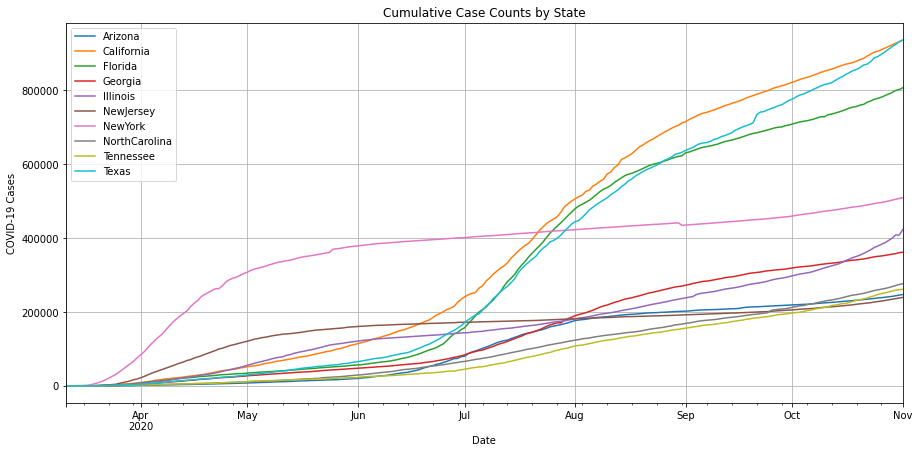

In [ ]:
state_case_plot = (
    state_cases
    .loc[state_cases.state.isin(large_outbreak_states[:10])]
    .set_index('date')
    .groupby(['state'])['JHU_ConfirmedCases']
    .plot()
)

plt.grid(True)
plt.legend()
plt.title("Cumulative Case Counts by State")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.show()

# When will it converge? - Estimation by sigmoid fitting

In [ ]:
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio

In [ ]:
# top30_countries = top_country_df.sort_values('confirmed', ascending=False).iloc[:30]['country'].unique()

In [ ]:
top30_countries = large_outbreak_states[:30]
df = (state_cases
    # .loc[state_cases.date == max(state_cases.date)]
    # .query('JHU_ConfirmedCases > 100000')
    # .sort_values('JHU_ConfirmedCases', ascending=False)
    )

In [ ]:
top30_countries

['Texas',
 'California',
 'Florida',
 'NewYork',
 'Illinois',
 'Georgia',
 'NorthCarolina',
 'Tennessee',
 'Arizona',
 'NewJersey',
 'Wisconsin',
 'Ohio',
 'Pennsylvania',
 'Michigan',
 'Alabama',
 'Missouri',
 'Louisiana',
 'Virginia',
 'Indiana',
 'SouthCarolina',
 'Massachusetts',
 'Minnesota',
 'Maryland',
 'Iowa',
 'Oklahoma',
 'Mississippi',
 'Utah',
 'Arkansas',
 'Colorado',
 'Kentucky']

In [ ]:
df.head()

metric,date,state,JHU_ConfirmedCases,JHU_ConfirmedDeaths,death_rate
0,2020-03-11,Alabama,0.0,0.0,0.000000
1,2020-03-11,Alaska,0.0,0.0,0.000000
2,2020-03-11,Arizona,9.0,0.0,0.000000
3,2020-03-11,Arkansas,0.0,0.0,0.000000
4,2020-03-11,California,178.0,4.0,0.022472


In [ ]:
df['confirmed'] = df['JHU_ConfirmedDeaths']

In [ ]:
df['country'] = df['state']

In [ ]:
df.query("state == 'Utah'")

metric,date,state,JHU_ConfirmedCases,JHU_ConfirmedDeaths,death_rate,confirmed,country
45,2020-03-11,Utah,3.0,0.0,0.000000,0.0,Utah
97,2020-03-12,Utah,3.0,0.0,0.000000,0.0,Utah
149,2020-03-13,Utah,9.0,0.0,0.000000,0.0,Utah
201,2020-03-14,Utah,10.0,0.0,0.000000,0.0,Utah
253,2020-03-15,Utah,18.0,0.0,0.000000,0.0,Utah
...,...,...,...,...,...,...,...
12057,2020-10-28,Utah,108803.0,588.0,0.005404,588.0,Utah
12109,2020-10-29,Utah,110640.0,598.0,0.005405,598.0,Utah
12161,2020-10-30,Utah,112932.0,601.0,0.005322,601.0,Utah
12213,2020-10-31,Utah,114656.0,604.0,0.005268,604.0,Utah


In [ ]:
country_df = df

In [ ]:
def sigmoid(t, M, beta, alpha, offset=0):
    alpha += offset
    return M / (1 + np.exp(-beta * (t - alpha)))

def error(x, y, params):
    M, beta, alpha = params
    y_pred = sigmoid(x, M, beta, alpha)

    # apply weight, latest number is more important than past.
    weight = np.arange(len(y_pred)) ** 2
    loss_mse = np.mean((y_pred - y) ** 2 * weight)
    return loss_mse

def gen_random_color(min_value=0, max_value=256) -> str:
    """Generate random color for plotly"""
    r, g, b = np.random.randint(min_value, max_value, 3)
    return f'rgb({r},{g},{b})'

In [ ]:
country_df.query('confirmed > 1000')['date'].min()

Timestamp('2020-04-03 00:00:00')

In [ ]:
train_start_date = df.query("state == 'Utah'").query('confirmed > 1000')['date'].min()

In [ ]:
type(train_start_date)

pandas._libs.tslibs.nattype.NaTType

In [ ]:
train_start_date = country_df.query('confirmed > 1000')['date'].min()
train_end_date = pd.to_datetime(target_date)

In [ ]:
df.query("state == 'Utah'").query('(date >= @train_start_date) & (date <= @train_end_date)')

In [ ]:
target_date = datetime.datetime.strptime(today, "%Y-%m-%d").timestamp()

In [ ]:
target_date = Timestamp('2020-11-03 00:00:00')

In [ ]:
country_df.query('confirmed > 1000')['date'].min()

Timestamp('2020-04-03 00:00:00')

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
def fit_sigmoid(exclude_days=0):
    target_country_df_list = []
    pred_df_list = []
    for target_country in top30_countries:
        print('target_country', target_country)
        # --- Train ---
        target_country_df = country_df.query('country == @target_country')

        #train_start_date = target_country_df['date'].min()
        train_start_date = target_country_df.query('confirmed > 0')['date'].min()
        train_end_date = pd.to_datetime(target_date) - pd.Timedelta(f'{exclude_days} days')
        target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')
        if len(target_date_df) <= 7:
            print('WARNING: the data is not enough, use 7 more days...')
            train_start_date -= pd.Timedelta('7 days')
            target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')

        confirmed = target_date_df['confirmed'].values
        x = np.arange(len(confirmed))

        lossfun = lambda params: error(x, confirmed, params)
        res = sp.optimize.minimize(lossfun, x0=[np.max(confirmed) * 5, 0.04, 2 * len(confirmed) / 3.], method='nelder-mead')
        M, beta, alpha = res.x
        # sigmoid_models[key] = (M, beta, alpha)
        # np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)

        # --- Pred ---
        pred_start_date = target_country_df['date'].min()
        pred_end_date = pd.to_datetime('2021-01-01')
        days = int((pred_end_date - pred_start_date) / pd.Timedelta('1 days'))
        # print('pred start', pred_start_date, 'end', pred_end_date, 'days', days)

        x = np.arange(days)
        offset = (train_start_date - pred_start_date) / pd.Timedelta('1 days')
        print('train_start_date', train_start_date, 'offset', offset, 'params', M, beta, alpha)
        y_pred = sigmoid(x, M, beta, alpha, offset=offset)
        # target_country_df['confirmed_pred'] = y_pred

        all_dates = [pred_start_date + np.timedelta64(x, 'D') for x in range(days)]
        pred_df = pd.DataFrame({
            'date': all_dates,
            'country': target_country,
            'confirmed_pred': y_pred,
        })

        target_country_df_list.append(target_country_df)
        pred_df_list.append(pred_df)
    return target_country_df_list, pred_df_list

In [ ]:
def plot_sigmoid_fitting(target_country_df_list, pred_df_list, title=''):
    n_countries = len(top30_countries)

    # --- Plot ---
    fig = go.Figure()

    for i in range(n_countries):
        target_country = top30_countries[i]
        target_country_df = target_country_df_list[i]
        pred_df = pred_df_list[i]
        color = gen_random_color(min_value=20)
        # Prediction
        fig.add_trace(go.Scatter(
            x=pred_df['date'], y=pred_df['confirmed_pred'],
            name=f'{target_country}_pred',
            line=dict(color=color, dash='dash')
        ))

        # Ground truth
        fig.add_trace(go.Scatter(
            x=target_country_df['date'], y=target_country_df['confirmed'],
            mode='markers', name=f'{target_country}_actual',
            line=dict(color=color),
        ))
    fig.update_layout(
        title=title, xaxis_title='Date', yaxis_title='Confirmed cases')
    fig.show()

In [ ]:
target_country_df_list, pred_df_list = fit_sigmoid(exclude_days=30)

In [ ]:
configure_plotly_browser_state()
plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='Sigmoid fitting with all latest data')

In [ ]:
df_mortality = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
      "spec": {
        "ids": states,
        "expressions": ["NYT_AllCausesDeathsWeekly_Excess_Deaths"],
        "start": "2020-04-01",
        "end": "2020-05-01",
        "interval":"DAY"
      }
    },
    get_all = True
)


In [ ]:
df_mortality.head()

,dates,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Colorado_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Colorado_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Florida_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Florida_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Connecticut_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Connecticut_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,DistrictofColumbia_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,DistrictofColumbia_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Alaska_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Alaska_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,California_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,California_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Arkansas_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Arkansas_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Arizona_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Arizona_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Delaware_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Delaware_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Kentucky_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Kentucky_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Kansas_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Kansas_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Georgia_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Georgia_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Iowa_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Iowa_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Idaho_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Idaho_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Louisiana_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Louisiana_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Illinois_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Illinois_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Maine_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Maine_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Hawaii_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Hawaii_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Indiana_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,...,Oklahoma_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Oklahoma_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,Oregon_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,Oregon_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NorthDakota_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NorthDakota_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NewMexico_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NewMexico_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NewYork_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NewYork_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,PuertoRico_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,PuertoRico_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NewJersey_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NewJersey_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NorthCarolina_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NorthCarolina_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,SouthCarolina_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.data,SouthCarolina_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,RhodeIsland_UnitedStates.NYT_AllCausesDeathsWeekly_Excess_Deaths.da

In [ ]:
df_mortality = reshapeTimeseries(df_mortality)
df_mortality.head()

In [ ]:
len(df_mortality)

1560

In [ ]:
df_mortality

,date,variable,data,state,metric
0,2020-04-01,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly...,0,Alabama,NYT_AllCausesDeathsWeekly_Excess_Deaths
1,2020-04-02,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly...,0,Alabama,NYT_AllCausesDeathsWeekly_Excess_Deaths
2,2020-04-03,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly...,0,Alabama,NYT_AllCausesDeathsWeekly_Excess_Deaths
3,2020-04-04,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly...,0,Alabama,NYT_AllCausesDeathsWeekly_Excess_Deaths
4,2020-04-05,Alabama_UnitedStates.NYT_AllCausesDeathsWeekly...,0,Alabama,NYT_AllCausesDeathsWeekly_Excess_Deaths
...,...,...,...,...,...
1555,2020-04-26,Wisconsin_UnitedStates.NYT_AllCausesDeathsWeek...,0,Wisconsin,NYT_AllCausesDeathsWeekly_Excess_Deaths
1556,2020-04-27,Wisconsin_UnitedStates.NYT_AllCausesDeathsWeek...,0,Wisconsin,NYT_AllCausesDeathsWeekly_Excess_Deaths
1557,2020-04-28,Wisconsin_UnitedStates.NYT_AllCausesDeathsWeek...,0,Wisconsin,NYT_AllCausesDeathsWeekly_Excess_Deaths
1558,2020-04-29,Wisconsin_UnitedStates.NYT_AllCausesDeathsWeek...,0,Wisconsin,NYT_AllCausesDeathsWeekly_Excess_Deaths
